In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext lab_black
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import cv2
import os

random_seed = 1
torch.manual_seed(random_seed)

DATA_DIR = "../data/time/"

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Read and prepare the data and data labels

In [20]:
df = pd.read_csv("../data/time/clocks.csv")

In [21]:
df.head()

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train


In [22]:
df["class index"].unique().size

144

In [23]:
train_files = df[df["data set"] == "train"]["filepaths"]
val_files = df[df["data set"] == "valid"]["filepaths"]
test_files = df[df["data set"] == "test"]["filepaths"]

print(f"Train files len: {len(train_files)}")
print(f"Val files len: {len(val_files)}")
print(f"Test files len: {len(test_files)}")

Train files len: 11520
Val files len: 1440
Test files len: 1440


In [24]:
train_labels = df[df["data set"] == "train"]["class index"]
val_labels = df[df["data set"] == "valid"]["class index"]
test_labels = df[df["data set"] == "test"]["class index"]

In [25]:
print(len(train_labels))

11520


In [26]:
print(train_files.head())

0     train/1-00/0.jpg
1     train/1-00/1.jpg
2    train/1-00/11.jpg
3    train/1-00/12.jpg
4    train/1-00/13.jpg
Name: filepaths, dtype: object


In [27]:
def cv2_imread(path):
    img = cv2.imread(path)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        pass
    return img

In [28]:
train_files = [os.path.join(DATA_DIR, path) for path in train_files]
val_files = [os.path.join(DATA_DIR, path) for path in val_files]
test_files = [os.path.join(DATA_DIR, path) for path in test_files]

In [29]:
train_images = [cv2_imread(f) for f in train_files]
val_images = [cv2_imread(f) for f in val_files]
test_images = [cv2_imread(f) for f in test_files]

In [30]:
# Lets check that the length has not varied
print(f"Length of train_images: {len(train_images)}")
print(f"Length of val_images: {len(val_images)}")
print(f"Length of test_images: {len(test_images)}")

Length of train_images: 11520
Length of val_images: 1440
Length of test_images: 1440


#### Plot some samples

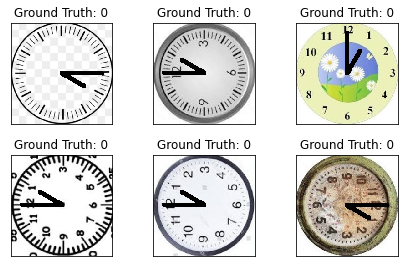

In [31]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(train_images[i], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {train_labels[i]}")
    plt.xticks([])
    plt.yticks([])

#### Convert to array

In [32]:
X_train = np.array(train_images).astype("float32")
X_val = np.array(val_images).astype("float32")
X_test = np.array(test_images).astype("float32")

In [33]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

Format

In [34]:
# X_train = X_train.transpose(0, 3, 1, 2)
# X_val = X_val.reshape(X_val.shape[0], 3, 224, 224)
# X_test = X_test.reshape(X_test.shape[0], 3, 224, 224)

Normalize (dividing by 255)

In [35]:
(X_train, X_val, X_test) = X_train / 255, X_val / 255, X_test / 255

In [36]:
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shape:{y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(11520, 224, 224, 3)
y_train shape:(11520,)
X_val shape:(1440, 224, 224, 3)
y_val shape:(1440,)
X_test shape:(1440, 224, 224, 3)
y_test shape:(1440,)


In [37]:
# dataset = np.concatenate((X_train, X_val, X_test), axis=0)
# dataset_mean = np.mean(dataset)
# dataset_std = dataset.std()

## Start with the Neural Network part

In [38]:
from torch.utils.data import Dataset, DataLoader

In [39]:
batch_size = 64

### Load data for training

In [40]:
class Data(Dataset):
    # Constructor
    def __init__(self, X, y):
        self.X = torch.from_numpy(X_train)
        # Need to convert channels to the second value
        self.X = self.X.permute(0, 3, 1, 2)
        # Normalize with mean and std deviation
        # self.X = (self.X - dataset_mean) / dataset_std
        self.y = torch.from_numpy(y_train)
        self.len = self.X.shape[0]

    # Getting the data
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    # Getting length of the data
    def __len__(self):
        return self.len

In [41]:
training = Data(X_train, y_train)
testing = Data(X_test, y_test)
train_loader = DataLoader(dataset=training, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing, batch_size=batch_size, shuffle=True)

In [42]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [43]:
print(batch_idx, (example_data, example_targets))
print(example_data.shape)

0 (tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...

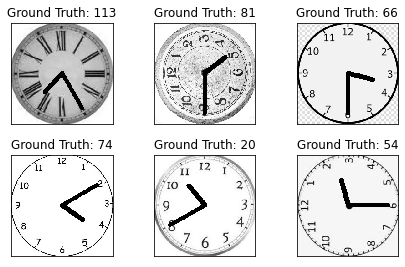

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])

In [45]:
for batch, (X, y) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 3, 224, 224])
y shape: torch.Size([64])


In [46]:
for data, target in test_loader:
    print(f"X shape: {data.shape}")
    print(f"y shape: {target.shape}")
    print(data)
    print(target)
    break

X shape: torch.Size([64, 3, 224, 224])
y shape: torch.Size([64])
tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # Default padding=0 and stride =1
        self.conv1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=8, stride=2)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(2880, 200)
        self.fc2 = nn.Linear(200, 144)

    def forward(self, x):
        # input shape: [64, 3, 224, 224]
        # output shape conv: [64, 10, 108, 108]
        # output shape pool: [64, 10, 54, 54]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # input shape: [64, 10, 54, 54]
        # output shape: [64, 20, 24, 24]
        # output shape pool: [64, 20, 12, 12]
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        # flatten input shape: [64, 20, 12, 12]
        # output shape: [64, 2880]
        x = x.view(-1, 2880)

        # input shape: [64, 2880]
        # output shape: [64, 50]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        # input shape: [64, 50]
        # output shape: [64, 10]
        x = self.fc2(x)
        softmax = F.log_softmax(x, 1)
        return softmax

In [48]:
# Hyperparameters
epochs = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10

network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [49]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [50]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.5f}",
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )
            torch.save(network.state_dict(), "./results/model.pth")
            torch.save(optimizer.state_dict(), "./results/optimizer.pth")

In [51]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        f"\nTest set: Avg. loss: {test_loss:.5f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.2f}%)\n"
    )

In [53]:
test()
for epoch in range(1, epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 4.97106, Accuracy: 80/11520 (0.69%)

Train Epoch: 1 [0/11520 (0.00%)]	Loss: 4.96774
Train Epoch: 1 [640/11520 (5.56%)]	Loss: 4.97265
Train Epoch: 1 [1280/11520 (11.11%)]	Loss: 4.96788
Train Epoch: 1 [1920/11520 (16.67%)]	Loss: 4.97321
Train Epoch: 1 [2560/11520 (22.22%)]	Loss: 4.98265
Train Epoch: 1 [3200/11520 (27.78%)]	Loss: 4.97738
Train Epoch: 1 [3840/11520 (33.33%)]	Loss: 4.97868
Train Epoch: 1 [4480/11520 (38.89%)]	Loss: 4.97049
Train Epoch: 1 [5120/11520 (44.44%)]	Loss: 4.97495
Train Epoch: 1 [5760/11520 (50.00%)]	Loss: 4.97528
Train Epoch: 1 [6400/11520 (55.56%)]	Loss: 4.98085
Train Epoch: 1 [7040/11520 (61.11%)]	Loss: 4.97857
Train Epoch: 1 [7680/11520 (66.67%)]	Loss: 4.96844
Train Epoch: 1 [8320/11520 (72.22%)]	Loss: 4.96160
Train Epoch: 1 [8960/11520 (77.78%)]	Loss: 4.97379
Train Epoch: 1 [9600/11520 (83.33%)]	Loss: 4.97205
Train Epoch: 1 [10240/11520 (88.89%)]	Loss: 4.97010
Train Epoch: 1 [10880/11520 (94.44%)]	Loss: 4.97223

Test set: Avg. loss: 4.969